다음의 코드 실행에 필요할 라이브러리를 설치하겠습니다.

In [ ]:
!pip install d2l==1.0.0-alpha0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 92 kB 1.3 MB/s 


#16.1 **Sentiment Analysis and the Dataset**
***
-   소셜미디어, 리뷰 플랫폼의 확산으로 여러 의견 데이터(opinionated data)가 기록되었고, 이를 통해 의견결정 과정(decision making process)을 지원할 큰 잠재력이 있다. ***감정분석(Sentiment Analysis)***은 제품 리뷰, 블로그 논평, 포럼 토론처럼 생산 텍스트에서 사람들의 감정(sentiment)을 연구한다.
  - 예:
      - 정치 - *정책에 대한 대중의 정서 분석*
      - 금융 - *시장의 정서 분석*
      - 마케팅 - *제품 연구 및 브랜드 관리 등등*

1. 감정 분석은 **text classification 과제**로 간주할 것이다. 과제는 다양한 length의 text sequence를 고정된 length의 text로 분류하는 것이 된다.
  - Sentiment는 여러 이산적인 극값이나 scale 등으로 표현 가능하기 때문  
예시:Positive or Negative

2. 본 챕터는 감정 분석을 위해 [Standford's Large movie review dataset](https://ai.stanford.edu/~amaas/data/sentiment)을 사용할 것이다. 
  - IMDb에서 다운로드한 25,000개의 영화리뷰를 train/test data set으로 구성
  - 동일한 수의 positive/negative label로 구성됨




In [ ]:
import os
import torch
from torch import nn
from d2l import torch as d2l

##  Reading the Dataset
* IMDb review dataset 다운로드 (path =  '../data/aclImdb')

In [ ]:
d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz',
                          '01ada507287d82875905620988597833ad4e0903')

data_dir = d2l.download_extract('aclImdb', 'aclImdb')

* training and test datasets 읽어오기  
 각각은 review들이고, label: 1 for "positive" 과 0 for "negative"로 구성됨


In [ ]:
def read_imdb(data_dir, is_train):
    """Read the IMDb review dataset text sequences and labels."""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test',
                                   label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label == 'pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True)
print('# trainings:', len(train_data[0]))
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

# trainings: 25000
label: 1 review: Rohmer strays from his usual portraits of french middle clas
label: 1 review: Johnny and June Carter Cash financed this film which is a tr
label: 1 review: I have seen The Perfect Son about three times. I fail to see


* train data 예시 (from 10009_3.txt - neg)  
>Cage plays a drunk and gets high critically praise. Elizabeth Shue Actually has to do a love seen with the most unattractive and overrated piece of dung flesh in Hollywood. I literally vomited while watching this film. Of course I had the flu, but that does not mean this film did not contribute to the vomit in the kamode. <br /><br />Why can't Nick Cage play something he can really pull off like a bad actor. Nick Cage who be brilliant in a role as a bad actor. Heck nobody could do it better.<br /><br />The search begins for Nick's contract with Lucifer or was it Lou Cipher from "Night Train To Terror".

## Preprocessing the Dataset

각 단어(word)를 기준으로 토큰화 하고, 5번보다 적게 나온 단어는 삭제해서 단어집합(vocabulary)를 만듦

In [ ]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

<details>
<summary> 참고 </summary>
<div markdown="1">       

Vocab class는 일련의 token sequence를 받아, min_freq 이상으로 존재하는 token에 대한 frequency와 해당 단어를 token_freqs에 tuple로 저장하고 있고, idx_to_token, token_to_idx 등으로 값을 바꿀 수 있다. reserved_token(vocab(<'pad'>))나 unknown token(vocab(<'unk'>)) 등을 이용해 token을 표현함.

```python
class Vocab:
    #Vocabulary for text.
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        """Defined in :numref:`sec_text-sequence`"""
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq])))
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx['<unk>']
```

</div>
</details>


In [ ]:
print(train_tokens[0][0])
print(vocab.token_freqs[24000])

Rohmer
('whistling', 12)


토큰화 이후, review의 토큰 길이를 histogram으로 표현


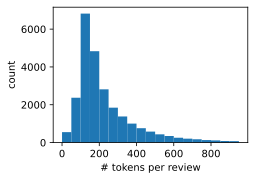

In [ ]:
d2l.set_figsize()
d2l.plt.xlabel('# tokens per review')
d2l.plt.ylabel('count')
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));

review 길이가 다양한 것을 확인할 수 있다. minibatch 수행을 위해서 review 길이를 500으로 정하고 padding, truncation한다.


In [ ]:
num_steps = 500  # sequence length
train_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([25000, 500])


## Creating Data Iterators

data iterator를 만들어, 각 iteration마다 minibatch가 return 되도록 만듦


In [ ]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64) #train_data = (data, label)

# def load_array(data_arrays, batch_size, is_train=True):
#     dataset = data.TensorDataset(*data_arrays)
#     return data.DataLoader(dataset, batch_size, shuffle=is_train)

for X, y in train_iter:
    print('X:', X.shape, ', y:', y.shape)
    break
print('# batches:', len(train_iter)) #64*391=25024

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


## Putting All Things Together

위의 과정을 모아서 "load_data_imdb" 함수를 만들 것이다. 이때, 이 함수는 training, test data iterator와 IMDb review dataset의 vocabulary를 return 한다.


In [ ]:
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset."""
    
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True)
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')

    #IMDb dataset의 vocabulary
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    
    #training, test data iterator
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)

    return train_iter, test_iter, vocab

## Summary

* 감정 분석은 text 속의 사람의 감정을 분석하며, 이는 text classification problem에 해당하며, 여러 길이의 text sequence를 특정 길이의 text category로 분류한다.
* 전처리 후에, 우리는 Stanford's large movie review dataset(IMDb review dataset)을 data iterator에 올리는 동시에, vocab도 생성할 수 있다.


[Discussions](https://discuss.d2l.ai/t/1387)


#16.2 **Sentiment Analysis: Using Recurrent Neural Networks**
***
사전에 훈련된 단어 벡터를 감정 분석에 이용할 것이다.  
16.1절의 IMDb Dataset은 크지 않기 때문에 large-scale corpora에서 사전학습된 텍스트 표현을 사용한다면 모델의 과적합을 줄일 수 있다. 아래 그림처럼 사전 훈련된 GloVe 모델을 사용하여 각 토큰을 나타내고, 이러한 토큰 표현을 Multilayer Bidirectional RNN에 입력시켜 텍스트 시퀀스 표현을 얻은 이후, 감정 분석 출력으로 변환시킨다.

![This section feeds pretrained GloVe to an RNN-based architecture for sentiment analysis.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/nlp-map-sa-rnn.svg?raw=1)


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## Representing Single Text with RNNs

다음의 BiRNN class에서 각 토큰은 embedding layer을 통해 개별적인 사전 훈련된 GloVe 표현을 얻고(self.embedding), 전체 text sequence는 양방향 RNN에 의해 encoding된다.(self.encoder)

초기 및 최종 time step에서 양방향 LSTM의 hidden state는 text sequence 표현에 의해 연결되게 되고, 이 단일 텍스트 표현은 최종적으로 fully connected layer(self.decoder)에 의해 2개의 출력("positive", "negative") 범주로 변환된다.

In [ ]:
class BiRNN(nn.Module):#timestep~문장길이, input~단어벡터, hidden~은닉상태크기
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional RNN
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2) #양방향*2, 초기최종*2

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

이제, 2개의 hidden layer로 구성된 양방향 RNN을 만들어 단일 텍스트를 표현할 것이다.


In [ ]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [ ]:
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights);

## Loading Pretrained Word Vectors

사전훈련된 100-d GloVe embedding을 불러온다.


In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

vocabulary에 있는 모든 token에 대한 GloVe의 embedding이 어떤 형태인지 출력해 본다.


In [ ]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

torch.Size([49346, 100])

이들 word vector는 이미 사전훈련된 값으로, 이 값들은 이후 훈련에서 학습시키지 않을 것이다.


In [ ]:
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad = False

## Training and Evaluating the Model

이제, 감정 분석을 위한 양방향 RNN을 학습해 본다.


loss 0.286, train acc 0.881, test acc 0.861
1043.1 examples/sec on [device(type='cuda', index=0)]


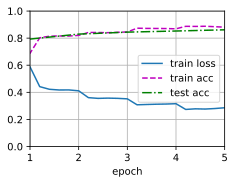

In [ ]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
devices = d2l.try_all_gpus()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

다음의 predict_sentiment 함수를 정의하여, 방금 학습한 모델인 'net'를 이용해 text sequence의 감정을 예측하는 기능을 담당하도록 할 것이다. 


In [ ]:
def predict_sentiment(net, vocab, sequence):
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

다음의 간단한 문장에 대한 감정예측을 시켜보자.
대략 잘 출력됨을 알 수 있다.

In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Summary

* 사전학습된 word vector(GloVe embedding 이용)는 text sequence 속의 각각의 개별적인 token을 표현한다.
* 양방향 RNN은 text sequence를 표현할 수 있으며, 이 신경망은 여러 hidden state를 초기부터 최종까지의 time step을 연결시키는 원리로 작동한다. 그리고 마지막의 FCN을 이용해 최종적인 2가지 범주 분류를 학습시킬 수 있었다.

[Discussions](https://discuss.d2l.ai/t/1424)


#16.3 **Sentiment Analysis: Using Convolutional Neural Networks**
***

 본래 몇 장 전에 배웠던 computer vision을 위해 구축된 신경망이지만, 자연어 처리 학습에도 많이 쓰이고 있다. 
 간단하게 생각해 본다면, 어떤 단일 text sequence는 1D image로 떠올릴 수 있다. 이때, 1D CNN을 이용하여 local feature를 추출해 볼 수 있을 것이다.(예: n-gram)
 본 절에서는 *text-CNN model*을 구축해 볼 것이다. 즉, 단일 text를 표현하기 위해 CNN architecture를 어떻게 구축해야 할 지에 초점을 둔다. 다만, 16.2절과의 차이는 중간에 구축하는 신경망의 종류가 양방향 RNN에서 CNN으로 바뀌었을 뿐이다.

![This section feeds pretrained GloVe to a CNN-based architecture for sentiment analysis.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/nlp-map-sa-cnn.svg?raw=1)


In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

## One-Dimensional Convolutions

*Model 설명에 앞서 1D CNN과 친해지는 과정이 서술되어 있습니다.*

1D CNN은 2D CNN의 cross-correlation operation 중에서 특별 case로 생각하면 된다. 

![One-dimensional cross-correlation operation. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times1+1\times2=2$.](http://d2l.ai/_images/conv1d.svg)

위의 그림처럼, 1D convolution에서는 convolution window가 input tensor의 왼쪽에서 오른쪽으로 slide해가며, 특정 위치의 input subtensor의 각 원소와 kernel tensor의 각 원소가 곱해져서 더해지며, 결국 single scalar 값이 출력된다.(오른쪽 Output의 파란색)

이제 우리는 1D cross-correlation을 다음의 corr1d 함수를 이용해 구축할 것이다. input X와 kernel K에 대해, 이 함수는 둘의 cross-correlation을 계산한 output Y를 출력한다.

In [ ]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i: i + w] * K).sum()
    return Y

In [ ]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2])
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

아래 그림처럼 여러 channel이 존재한다면(예: 아래처럼 3개의 channel) convolution kernel도 같은 channel 수만큼 존재해야 할 것이다.


![One-dimensional cross-correlation operation with 3 input channels. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $0\times1+1\times2+1\times3+2\times4+2\times(-1)+3\times(-3)=2$.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/conv1d-channel.svg?raw=1)

아래는 1-D cross-correlation 연산을 multiple input channel을 대상으로 할때의 함수를 위와 마찬가지로 표현한 것이다.


In [ ]:
def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

**포인트는 Multiple-input-channel의 1D cross correlation이라 생각했지만, 이는 사실 single-input-channel의 2D cross correlation으로 간주해도 된다는 점이다.**

위의 그림을 아래처럼 표현할 수 있으며, 이 경우 각각의 convolution kernel의 높이(height)는 input tensor와 같다.
Multiple output channel의 경우 7.4.2절에서처럼 같은 원리로 확장시킬 수 있다.
(2D convolution에서 kernel은 c_i\*c_o\*h*w차원)

![Two-dimensional cross-correlation operation with a single input channel. The shaded portions are the first output element as well as the input and kernel tensor elements used for the output computation: $2\times(-1)+3\times(-3)+1\times3+2\times4+0\times1+1\times2=2$.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/conv1d-2d.svg?raw=1)

## Max-Over-Time Pooling

pooling을 하여 여러 time step에 걸쳐진 sequence 표현 중 높은 값을 추출하여, 중요 feature를 얻어낼 수 있다. 본 예제에서 구축할 textCNN에서는 *max-over-time-pooling*을 사용할 것인데, 이는 1-D global max-pooling으로 생각하면 된다. 

**Multiple channel input에서 각 channel은 각각의 time step에 대한 값을 저장하고,** multiple channel output에서는 그 channel에서의 maximum 값만을 가지게 된다.
**Max-over-time pooling은 각각의 다른 channel별로 다른 숫자의 time step을 허용한다.**

## The textCNN Model

**이제 배울 textCNN 모델([Yoon Kim, 2014](https://arxiv.org/abs/1408.5882))은 방금 전 설명한 1-D convolution과 max-over-time pooling을 적용한 것이다.** 각각의 개별적인 사전학습된 token 표현을 input으로 받아, sequence 표현을 얻어내고, 변환하는 과정이 일어난다.


이제 구체적인 과정을 살펴본다.우선, 단일 text sequence가 n개의 token으로 구성되고, 각 token은 d-dimensional vector로 구성된다고 하자. 이때, input tensor의 width = n, height = 1, channel#=d가 된다.

1. Multipe 1-D kernel을 각각의 input에 대해 적용시켜 연산한다.아래 그림처럼 여러 width의 kernel로 정의한다면, 각각의 kernel은 다른 숫자의 인접 token에 대하여 local feature를 추출할 수 있게 만들 수 있다.
2. 이제 Max-Over-Time-Pooling을 얻은 모든 output channel에 대해 각각 적용시킨다. 그리고 각 channel에서 얻은 scalar pooling output들을 연결지어 vector로 만든다.
3. 연결지어 얻은 vector를 output category 수에 맞추어서 FCN을 구성시켜서 출력한다. (이때, 학습시에는 Dropout을 이용하여 overfitting을 줄인다.)

![The model architecture of textCNN.](http://d2l.ai/_images/textcnn.svg)

  * 그림 설명:
  input은 11개의 token을 구성된 문장 하나이며, 각 token은 6-d vector로 표현된다. 그러면 6개의 channel, 11의 width를 갖는 input tensor로 간주할 수 있고, 각각에 대해 2가지의 1D convolution kernel을 적용시킬 것이다.

  이때 좌측의 kernel은 width가 2, 우측의 kernel은 width가 4로 각각 output channel 수가 4, 5가 되도록 정의된다. 그렇다면, 우선 첫째 output은 좌측 kernel을 적용시킨 것은 width가 10, channel이 4, 우측 kernel을 적용시킨 것은 width가 8, channel이 5가 될 것이다. 이제, 각 channel 별로 pooling을 수행하면, 각각 4개, 5개의 scalar pooling output 값을 얻게 되고, 이를 연결지어 9-d vector를 얻을 수 있다. 그리고 이는 최종적으로 2-D output vector로 변환되어 binary classification을 수행한다.


>***textCNN figure(Yoon Kim, 2014)***
![img](http://i.imgur.com/JN72JHW.png)
실제 논문에서는
- 처음에 *n*x*k*의 표현을 2가지 층으로 구성해서, 하나는 역전파 학습가능하게, 다른하나는 불가능하게 구성해서 실험을 진행 -> rand,static,nonstatic,multichannel 비교
- word2vec(300-d) 사용, cbow 학습
- 결과: 
  - Multichannel이 딱히 overfitting 방지하는 효과를 주지는 않음.
  - static(단어벡터까지 학습): bad와 유사한 good, non-static: bad와 유사한 terrible
  - w2v에서는 good과 great이 가장 유사. 그러나 fine-tuning 이후 good과 유사한 단어는 nice.(실제 감정 묘사에서 nice가 가깝다)
- 결론: word2vec 위에 간단한 CNN과 튜닝만 거쳐 훌륭한 성능을 보임. 앞으로 비지도 학습 단어 벡터가 NLP에 중요 재료가 될 근거를 알려줌.




### Defining the Model

Model을 다음과 같이 정의한다. 다만 앞의 RNN 모델과의 차이점은, 단순 architecture가 변한 것 외에도, 2개의 embedding layer를 사용한다는 점이다. 하나는 trainable weigth를 가지고, 다른 하나는 고정 값이다.


In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # The embedding layer not to be trained
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        # The max-over-time pooling layer has no parameters, so this instance
        # can be shared
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional convolutional layers
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))

    def forward(self, inputs):
        # Concatenate two embedding layer outputs with shape (batch size, no.
        # of tokens, token vector dimension) along vectors
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-dimensional convolutional layers,
        # rearrange the tensor so that the second dimension stores channels
        embeddings = embeddings.permute(0, 2, 1)
        # For each one-dimensional convolutional layer, after max-over-time
        # pooling, a tensor of shape (batch size, no. of channels, 1) is
        # obtained. Remove the last dimension and concatenate along channels
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

textCNN 인스턴스를 다음과 같이 Kernel width가 3,4,5를 가진 3 convolutional layer가 되도록 구성하자.

In [ ]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
devices = d2l.try_all_gpus()
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);

### Loading Pretrained Word Vectors

16.2절처럼 사전학습된 100-d GloVe embedding을 불러온다. 단, embedding은 학습과정에서 weight가 변하고, fixed embedding은 학습과정에서 값이 일정하다.

In [ ]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.data.copy_(embeds)
net.constant_embedding.weight.requires_grad = False

### Training and Evaluating the Model

학습을 진행한다.


loss 0.063, train acc 0.980, test acc 0.875
2595.1 examples/sec on [device(type='cuda', index=0)]


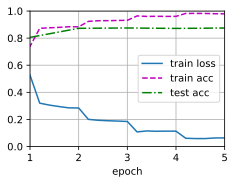

In [ ]:
lr, num_epochs = 0.001, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

Below we use the trained model to predict the sentiment for two simple sentences.


In [ ]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [ ]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Summary

* 1-D CNN들은 n-gram처럼 local feature를 처리할 수 있다.
* Multi-input-channel 1-D cross-correlation는 single-input-channel 2-D cross-correlation과 동일하다.
* Max-Over-Time Pooling은 다른 channel에 대한 여러 time step을 허용한다.
* textCNN 모델은 1-D CNN과 max-over-time pooling을 이용해 개별적인 token 표현을 downstream application output들로 변환시킨다.

[Discussions](https://discuss.d2l.ai/t/1425)
